# **Passenger Load Prediction Project**

### **2 Pax Load Factor Prediction**

This notebook builds the reproducible machine learning pipeline for predicting the passenger load factor per flight route. The cleaned dataset generated in the previous exploratory and preprocessing phase (see 1_eda_cleaning_featureengineering.ipynb) is used. The goal is to develop a robust model that can support airlines in optimizing route planning and capacity management.

The goal of the model is to predict the **Passenger Load Factor** per flight route. This value represents the ratio between passengers carried and available seats, indicating how efficiently the aircraft capacity is utilized.

In the first part of the analysis, all routes are randomly split into training and test data, meaning that some flights of the same route may appear in both sets. This provides an initial benchmark of model performance under familiar conditions.
In the second and more business-relevant part, the focus shifts to unseen routes. Here, the model is trained and evaluated using a route-based split to simulate predictions for completely new connections.

**Import packages**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupShuffleSplit
import shap
from IPython.display import display, Markdown
import joblib
import warnings

In [3]:
# Ignore future warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)

**Read the cleaned data**

Dataset Structure and Input Requirements:

This notebook assumes a preprocessed dataset as produced by `1_eda_cleaning_featureengineering.ipynb`.

The dataset must contain the following columns:
- `departures_performed` (numeric): Number of flights performed
- `payload` (numeric): Total payload weight in kg
- `freight` (numeric): Freight load in kg
- `mail` (numeric): Mail load in kg
- `distance` (numeric): Flight distance in km
- `air_time` (numeric): Average flight duration in 
- `carrier_group` (categorical): Airline group
- `aircraft_type` (categorical): Aircraft model or category
- `aircraft_config` (categorical): Aircraft configuration (seating layout or variant)
- `route` (categorical): Combination of origin and destination airport codes
- `route_type` (categorical): Route classification: domestic (within the U.S.) or international/unknown
- `pax_load_factor` (numeric): Target variable, percentage of passenger seat occupancy

In [4]:
# Read data
pax_load_data = pd.read_csv('../data/passenger_load_data.csv')

**Define features and target y - Separate for known and unknown routes**

While 'route' is kept in the categorical feture set for the first scenario, it is excluded for the second scenario.

In [5]:
# Define target
target = "pax_load_factor"

# Drop target & non-feature columns
X = pax_load_data.drop(columns=[target])
y = pax_load_data[target]

# Define feature types
num_features = ['departures_performed', 'payload', 'freight', 'mail', 'distance', 'air_time']
cat_features = ['carrier_group', 'aircraft_type', 'aircraft_config', 'route', 'route_type']

# For known routes scenario: include 'route' in categorical features
cat_features_known = cat_features.copy() 

# For new routes scenario: exclude 'route' from categorical features
cat_features_new = [feat for feat in cat_features if feat != 'route']

print("Numerical features:", num_features)
print("Categorical features (known routes):", cat_features_known)
print("Categorical features (new routes):", cat_features_new)

Numerical features: ['departures_performed', 'payload', 'freight', 'mail', 'distance', 'air_time']
Categorical features (known routes): ['carrier_group', 'aircraft_type', 'aircraft_config', 'route', 'route_type']
Categorical features (new routes): ['carrier_group', 'aircraft_type', 'aircraft_config', 'route_type']


**Preprocessing: Imputing, scaling and encoding**

Numerical features are imputed (median) and scaled. Categorical features are imputed (most frequent) and one-hot encoded. Even though the current dataset has no missing values, imputers are included to ensure robustness on operational data.

Two separate preprocessors are used: One for known routes, where all route categories are present during training and one for unseen routes, which excludes route information from categorical encoding to ensure the model can generalize to new connections.

In [ ]:
# Create two different preprocessors for the two scenarios
# Preprocessor for known routes (includes route as feature)
preprocessor_known = ColumnTransformer(
    transformers=[
        ("num",
         Pipeline([("imputer", SimpleImputer(strategy="median")),
                   ("scaler", StandardScaler())]),
         num_features),
        ("cat",
         Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                   ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))]),
         cat_features_known),  
    ],
    remainder="drop",
)

# Preprocessor for new routes (excludes route as feature)
preprocessor_new = ColumnTransformer(
    transformers=[
        ("num",
         Pipeline([("imputer", SimpleImputer(strategy="median")),
                   ("scaler", StandardScaler())]),
         num_features),
        ("cat",
         Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                   ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))]),
         cat_features_new), 
    ],
    remainder="drop",
)

#### **Prediction of new flights on known routes**

**Split the data into train- and test data**

The dataset is divided into training and test sets using an 80/20 split.

In [7]:
# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Check shape of train data**

In [8]:
# Check shape
X_train.shape

(287535, 11)

**Define models**

To evaluate different approaches for predicting the load factor, several regression models are compared, including linear and tree-based methods. A baseline model that always predicts the mean load factor is included to benchmark the added value of the trained models.

In [9]:
models = {
    "Baseline (Mean)": DummyRegressor(strategy="mean"),
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=12, n_jobs=-1,random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(max_depth=3, n_estimators=200, random_state=42)
}

**Train, predict and evaluate results**

Each model is trained and evaluated using a pipeline. Performance is assessed through 3-fold cross-validation on the training data and a test set evaluation.
Key metrics are R², MAE and RMSE.

In [10]:
evaluation_results = []

CV = 3

for name, model in models.items():
    # Use the known routes preprocessor for the main evaluation (regular train/test split)
    pipeline = Pipeline([
        ("preprocessing", preprocessor_known),  
        ("model", model)
    ])

    # Cross-validation
    cv = cross_validate(pipeline, X_train, y_train, cv=CV, scoring={"r2": "r2", "mae": "neg_mean_absolute_error", "rmse": "neg_root_mean_squared_error"}, n_jobs=-1, return_train_score=False)

    # Train the model
    pipeline.fit(X_train, y_train)   

    # Predict target
    y_pred = pipeline.predict(X_test)

    evaluation_results.append({
        "Model": name,
        "CV_R2_Mean": np.mean(cv["test_r2"]),
        "CV_MAE_Mean": -np.mean(cv["test_mae"]),
        "CV_RMSE_Mean": -np.mean(cv["test_rmse"]),
        "Test_R2": r2_score(y_test, y_pred),
        "Test_MAE": mean_absolute_error(y_test, y_pred),
        "Test_RMSE": np.sqrt(mean_squared_error(y_test, y_pred))
    })

# Convert results to DataFrame
results_df = pd.DataFrame(evaluation_results).sort_values("Test_R2", ascending=False)
results_df

,Model,CV_R2_Mean,CV_MAE_Mean,CV_RMSE_Mean,Test_R2,Test_MAE,Test_RMSE
1,Linear Regression,0.477121,0.107154,0.150849,0.486066,0.106650,0.150261
2,Random Forest,0.463624,0.113184,0.152781,0.467010,0.113437,0.153022
3,Gradient Boosting,0.445229,0.116041,0.155380,0.446033,0.116780,0.156004
0,Baseline (Mean),-0.000014,0.159651,0.208616,-0.000069,0.160471,0.209608


In [11]:
# Identify best model
best_row = results_df.loc[results_df["Test_R2"].idxmax()]

best_model_name = best_row["Model"]
best_model_r2 = best_row["Test_R2"]
best_model_mae = best_row["Test_MAE"]
best_model_rmse = best_row["Test_RMSE"]

print("Best Performing Model (by R²):")
print(f"Model: {best_model_name}")
print(f"R² on Test Set: {best_model_r2:.3f}")
print(f"MAE on Test Set: {best_model_mae:.3f}")
print(f"RMSE on Test Set: {best_model_rmse:.3f}")

Best Performing Model (by R²):
Model: Linear Regression
R² on Test Set: 0.486
MAE on Test Set: 0.107
RMSE on Test Set: 0.150


**Prediction vs Actual and Residual Analysis**

This section visualizes how well the best-performing model fits the data by comparing predicted and actual passenger load factors and analyzing residual error distributions.

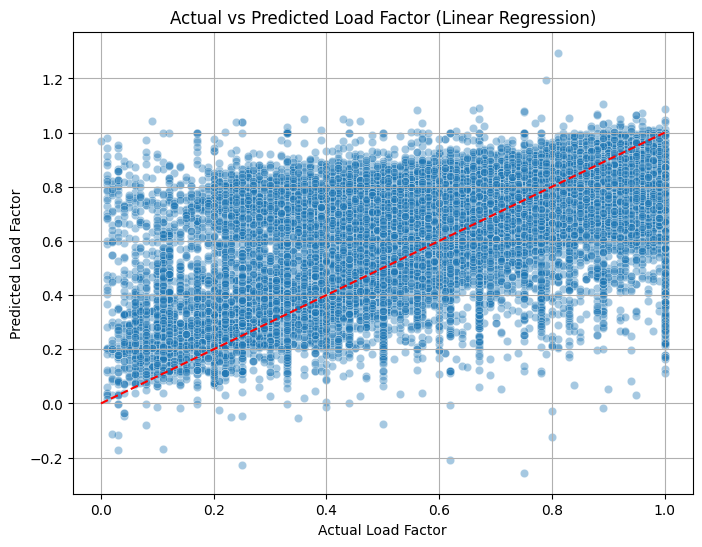

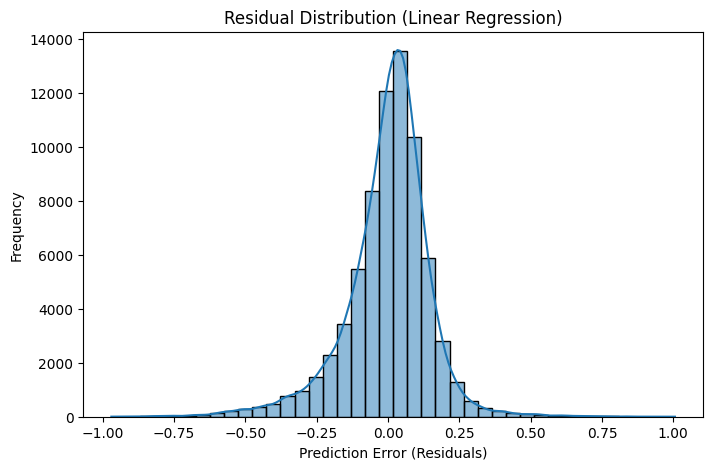

In [12]:
# Retrain best model on full training data and predict on test set
best_model_known = models[best_model_name]
best_pipeline = Pipeline([
    ("preprocessing", preprocessor_known),  
    ("model", best_model_known)
])
best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)

# Plot Actual vs Predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title(f"Actual vs Predicted Load Factor ({best_model_name})")
plt.xlabel("Actual Load Factor")
plt.ylabel("Predicted Load Factor")
plt.grid(True)
plt.show()

# Residuals Plot
residuals = y_test - y_pred
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=40, kde=True)
plt.title(f"Residual Distribution ({best_model_name})")
plt.xlabel("Prediction Error (Residuals)")
plt.ylabel("Frequency")
plt.show()


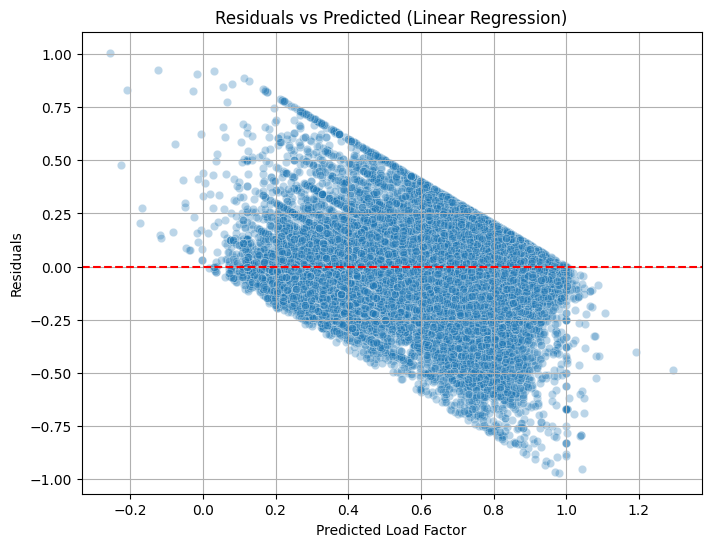

In [13]:
# Plot Predicted vs Residuals
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title(f"Residuals vs Predicted ({best_model_name})")
plt.xlabel("Predicted Load Factor")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()


**Hyperparameter tuning of the best model**

The best-performing model from the previous evaluation is optimized using RandomizedSearchCV or GridSearchCV, depending on the model type. Different parameter combinations are explored to improve prediction performance.

In [14]:
# Use best model for hyperparameter tuning
best_model_known = models[best_model_name]

# Define parameter space based on the best model type
if isinstance(best_model_known, RandomForestRegressor):
    params = {
        "model__n_estimators": randint(100, 500),
        "model__max_depth": [None, 10, 20, 30, 40, 50],
        "model__min_samples_split": randint(2, 10),
        "model__min_samples_leaf": randint(1, 5),
        "model__max_features": ["sqrt", "log2"]
    }
elif isinstance(best_model_known, GradientBoostingRegressor):
    params = {
        "model__n_estimators": randint(100, 300),
        "model__max_depth": [3, 5, 7, 10],
        "model__learning_rate": [0.01, 0.1, 0.2],
        "model__min_samples_split": randint(2, 10),
        "model__min_samples_leaf": randint(1, 5)
    }
elif isinstance(best_model_known, LinearRegression):
    params = [
        # Ridge Regression
        {
            "model": [Ridge()],
            "model__alpha": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
        },
        # Lasso Regression
        {
            "model": [Lasso()],
            "model__alpha": [0.001, 0.01, 0.1, 1.0, 10.0],
            "model__max_iter": [1000, 2000]
        },
        # ElasticNet
        {
            "model": [ElasticNet()],
            "model__alpha": [0.001, 0.01, 0.1, 1.0, 10.0],
            "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
            "model__max_iter": [1000, 2000]
        }
    ]
else:
    params = None

if params is not None:
    # Create a new instance of the best model for tuning
    if isinstance(best_model_known, RandomForestRegressor):
        model_for_tuning = RandomForestRegressor(random_state=42, n_jobs=-1)
    elif isinstance(best_model_known, GradientBoostingRegressor):
        model_for_tuning = GradientBoostingRegressor(random_state=42)
    elif isinstance(best_model_known, LinearRegression):
        model_for_tuning = LinearRegression()
    
    # Define pipeline using the best model
    rs_pipeline = Pipeline([
        ("preprocessing", preprocessor_known),  
        ("model", model_for_tuning)
    ])
else:
    print("Using the original best model without additional tuning.")
    rs_pipeline = None

# Only proceed with RandomizedSearch if there are hyperparameters to tune
if rs_pipeline is not None:
    if isinstance(best_model_known, LinearRegression):
        random_search = GridSearchCV(
            rs_pipeline,
            param_grid=params,
            cv=5,                      
            scoring="r2",              
            n_jobs=-1,                 
            verbose=2
        )
    else:
        # For other models use RandomizedSearchCV
        random_search = RandomizedSearchCV(
            rs_pipeline,
            param_distributions=params,
            n_iter=25,  
            cv=3,                      
            scoring="r2",              
            n_jobs=-1,                 
            verbose=2,
            random_state=42
        )

    # Fit search
    random_search.fit(X_train, y_train)

    # Best parameters and score
    print("Best Parameters:")
    print(random_search.best_params_)
    print(f"\nBest CV R² Score: {random_search.best_score_}")
else:
    print("Skipping hyperparameter tuning - not applicable for the current best model.")

Fitting 5 folds for each of 66 candidates, totalling 330 fits
[CV] END ..................model=Ridge(), model__alpha=0.001; total time=   4.9s
[CV] END ..................model=Ridge(), model__alpha=0.001; total time=   4.9s
[CV] END ..................model=Ridge(), model__alpha=0.001; total time=   5.2s
[CV] END ...................model=Ridge(), model__alpha=0.01; total time=   5.1s
[CV] END ...................model=Ridge(), model__alpha=0.01; total time=   5.0s
[CV] END ..................model=Ridge(), model__alpha=0.001; total time=   5.3s
[CV] END ...................model=Ridge(), model__alpha=0.01; total time=   5.3s
[CV] END ..................model=Ridge(), model__alpha=0.001; total time=   4.4s
[CV] END ...................model=Ridge(), model__alpha=0.01; total time=   4.9s
[CV] END ....................model=Ridge(), model__alpha=0.1; total time=   4.7s
[CV] END ...................model=Ridge(), model__alpha=0.01; total time=   5.0s
[CV] END ....................model=Ridge(), mod

**Evaluate the best tuned model on the test set**

In [15]:
# Select best estimator
best_pipeline = random_search.best_estimator_   
y_pred_tuned = best_pipeline.predict(X_test)

# Evaluation metrics
r2  = r2_score(y_test, y_pred_tuned)
mae = mean_absolute_error(y_test, y_pred_tuned)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_tuned))

print("Test R²:",  round(r2, 3))
print("Test MAE:", round(mae, 3))
print("Test RMSE:", round(rmse, 3))

Test R²: 0.504
Test MAE: 0.106
Test RMSE: 0.148


**Hyperparameter tuning results analysis**

Numerical and visual comparison of the model’s predictive performance before and after hyperparameter tuning.

Performance Comparison:
                     Model      R2     MAE    RMSE
0        Linear Regression  0.4861  0.1067  0.1503
1  Tuned Linear Regression  0.5040  0.1061  0.1476

Performance Changes after Tuning:
R² change: 0.0180 (improvement)
MAE change: -0.0005 (improvement)
RMSE change: -0.0026 (improvement)

Best parameters found:
model: Ridge()
model__alpha: 1.0


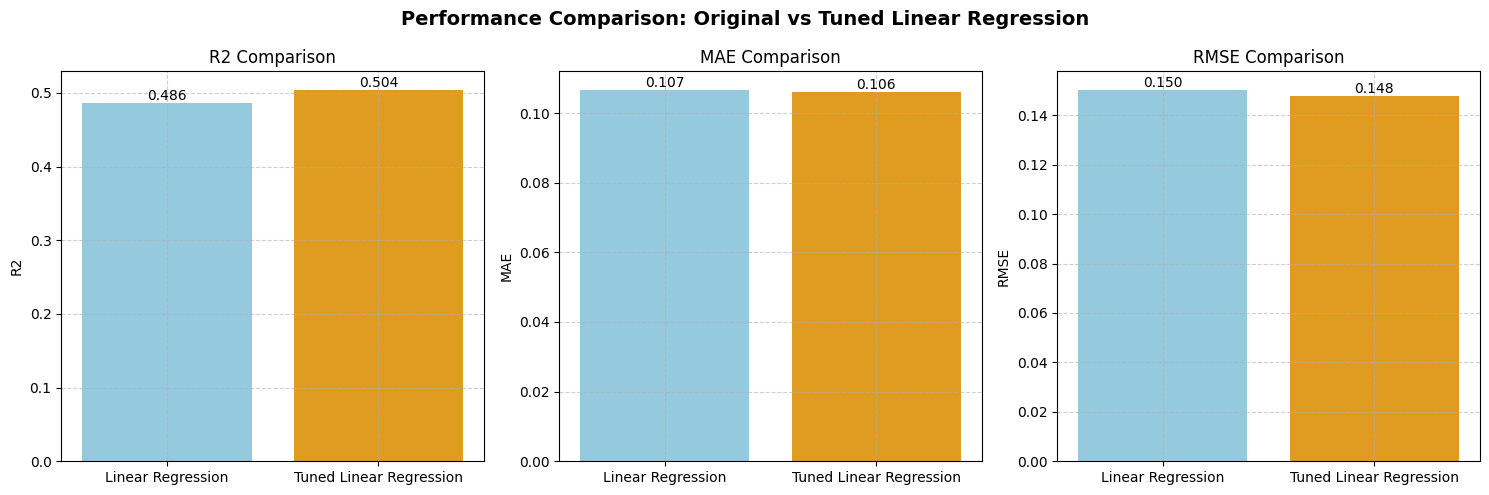

In [16]:
# Compare the original vs the tuned version
# Initial metrics of the original best model
initial_results = {
    "Model": best_model_name,
    "R2": results_df.loc[results_df["Model"] == best_model_name, "Test_R2"].values[0],
    "MAE": results_df.loc[results_df["Model"] == best_model_name, "Test_MAE"].values[0],
    "RMSE": results_df.loc[results_df["Model"] == best_model_name, "Test_RMSE"].values[0],
}

# Tuned model (from hyperparameter search)
best_tuned = random_search.best_estimator_
y_pred_tuned = best_tuned.predict(X_test)

tuned_results = {
    "Model": f"Tuned {best_model_name}",
    "R2": r2_score(y_test, y_pred_tuned),
    "MAE": mean_absolute_error(y_test, y_pred_tuned),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_tuned))
}

# Compare results
compare_df = pd.DataFrame([initial_results, tuned_results])
print("Performance Comparison:")
print(compare_df.round(4))

# Calculate improvement/degradation
r2_change = tuned_results["R2"] - initial_results["R2"]
mae_change = tuned_results["MAE"] - initial_results["MAE"]
rmse_change = tuned_results["RMSE"] - initial_results["RMSE"]

print(f"\nPerformance Changes after Tuning:")
print(f"R² change: {r2_change:.4f} ({'improvement' if r2_change > 0 else 'degradation'})")
print(f"MAE change: {mae_change:.4f} ({'improvement' if mae_change < 0 else 'degradation'})")
print(f"RMSE change: {rmse_change:.4f} ({'improvement' if rmse_change < 0 else 'degradation'})")

# Check the best parameters found
print(f"\nBest parameters found:")
for param, value in random_search.best_params_.items():
    print(f"{param}: {value}")

# Visualize comparison
metrics = ["R2", "MAE", "RMSE"]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, metric in enumerate(metrics):
    sns.barplot(
        data=compare_df,
        x="Model",
        y=metric,
        ax=axes[i],
        palette=["skyblue", "orange"]
    )
    axes[i].set_title(f"{metric} Comparison")
    axes[i].set_xlabel("")
    axes[i].set_ylabel(metric)
    axes[i].grid(True, linestyle="--", alpha=0.6)
    
    # Add value labels on bars
    for container in axes[i].containers:
        axes[i].bar_label(container, fmt='%.3f')

plt.suptitle(f"Performance Comparison: Original vs Tuned {best_model_name}", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

**Grid Search for fine-tuning the best model**

A grid search explores a smaller, targeted parameter space to fine-tune the model based on the results of the randomized search.

In [17]:
# Grid Search parameter search with reasonable bounds based on best model
if isinstance(best_model_known, RandomForestRegressor):
    gs_params = {
        "model__n_estimators": [100, 120],          # 2 values around the original
        "model__max_depth": [10, 12, 15],           # 3 values around the original
        "model__min_samples_split": [2, 5],         
        "model__max_features": ["sqrt", "log2"]     
    }
    model_for_gs = RandomForestRegressor(random_state=42)
elif isinstance(best_model_known, GradientBoostingRegressor):
    gs_params = {
        "model__n_estimators": [100, 150, 200],
        "model__max_depth": [3, 5, 7],
        "model__learning_rate": [0.1, 0.15, 0.2]
    }
    model_for_gs = GradientBoostingRegressor(random_state=42)
elif isinstance(best_model_known, LinearRegression):
    print("For Linear Regression, grid search would be redundant with the randomized search already performed.")
    gs_params = None
    model_for_gs = None
else:
    print(f"Grid search not implemented for {type(best_model_known).__name__}")
    gs_params = None
    model_for_gs = None

if gs_params is not None:
    gs_pipeline = Pipeline([
        ("preprocessing", preprocessor_known),
        ("model", model_for_gs)
    ])

    gs_search = GridSearchCV(
        gs_pipeline,
        param_grid=gs_params,
        cv=5,
        scoring="r2",
        n_jobs=-1,
        verbose=1
    )

    gs_search.fit(X_train, y_train)

    print("Best Grid Search Parameters:")
    print(gs_search.best_params_)
    print(f"Best CV R² Score: {gs_search.best_score_:.4f}")

    # Test the grid search model
    y_pred_gs = gs_search.best_estimator_.predict(X_test)
    gs_r2 = r2_score(y_test, y_pred_gs)
    gs_mae = mean_absolute_error(y_test, y_pred_gs)
    gs_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gs))

    print(f"\nGrid Search Model Test Results:")
    print(f"R²: {gs_r2:.4f}")
    print(f"MAE: {gs_mae:.4f}")
    print(f"RMSE: {gs_rmse:.4f}")

    # Compare all three approaches
    comparison_data = [
        {"Model": f"Original {best_model_name}", "R2": initial_results["R2"], "MAE": initial_results["MAE"], "RMSE": initial_results["RMSE"]},
        {"Model": f"Randomized Search", "R2": tuned_results["R2"], "MAE": tuned_results["MAE"], "RMSE": tuned_results["RMSE"]},
        {"Model": f"Grid Search", "R2": gs_r2, "MAE": gs_mae, "RMSE": gs_rmse}
    ]

    final_comparison = pd.DataFrame(comparison_data)
    print("\n" + "="*50)
    print("Final Comparison:")
    print("="*50)
    print(final_comparison.round(4))
else:
    print("Skipping grid search - not applicable for the current best model or would be redundant.")

For Linear Regression, grid search would be redundant with the randomized search already performed.
Skipping grid search - not applicable for the current best model or would be redundant.


**Feature importance analysis (SHAP vs. Coefficients) based on a data sample**

Feature importance is computed using SHAP values for tree-based models to capture non-linear effects, while linear models rely on regression coefficients to interpret direct feature relationships.

Performing coefficient analysis for Linear Regression


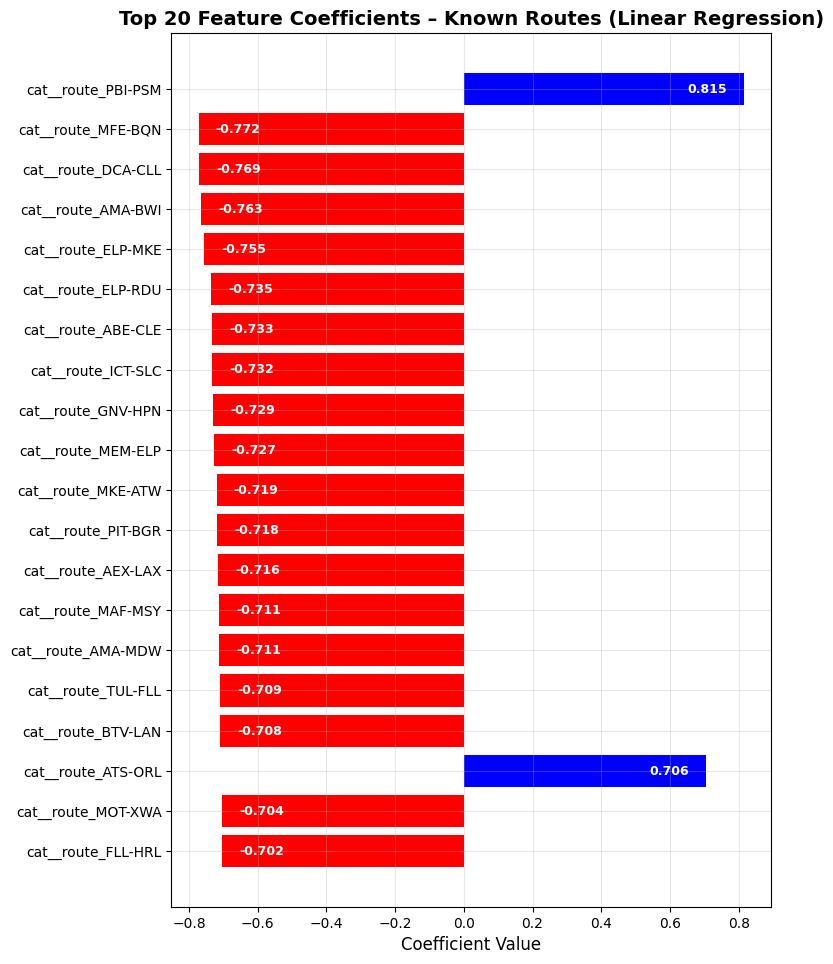

Linear Regression R² Score: 0.4861
Number of features: 20585
Features with positive impact: 11762
Features with negative impact: 8823


In [18]:
# Define best pipeline for regular split
best_pipeline_known = Pipeline([
    ("preprocessing", preprocessor_known),
    ("model", best_model_known)
])
best_pipeline_known.fit(X_train, y_train)

# Check if we can do feature importance analysis
model_known = best_pipeline_known.named_steps["model"]
X_test_transformed_known = best_pipeline_known.named_steps["preprocessing"].transform(X_test)

# Convert sparse matrix to dense array for SHAP
if hasattr(X_test_transformed_known, 'toarray'):
    X_test_transformed_known = X_test_transformed_known.toarray()

# Get feature names
feature_names_known = best_pipeline_known.named_steps["preprocessing"].get_feature_names_out()

# Check model type and apply appropriate analysis
if isinstance(model_known, (RandomForestRegressor, GradientBoostingRegressor)):
    print("Performing SHAP analysis for tree-based model")
    
    # Use a sample for faster SHAP analysis
    sample_size = min(1000, X_test_transformed_known.shape[0])  # Use up to 1000 samples
    print(f"Using {sample_size} samples for SHAP analysis (out of {X_test_transformed_known.shape[0]} total)")

    # Take a random sample
    np.random.seed(42)
    sample_indices_known = np.random.choice(X_test_transformed_known.shape[0], sample_size, replace=False)
    X_sample_known = X_test_transformed_known[sample_indices_known]

    # SHAP TreeExplainer for tree-based models
    explainer_known = shap.TreeExplainer(model_known)
    shap_values_known = explainer_known.shap_values(X_sample_known)

    # Summary Plot 
    shap.summary_plot(
        shap_values_known,
        X_sample_known,
        feature_names=feature_names_known,
        plot_type="bar",
        show=False)

    # Add title
    plt.title("Feature Importance – Known Routes (SHAP)", fontsize=14, fontweight="bold")

    # Access the current axis
    ax = plt.gca()

    # Add bar labels
    for container in ax.containers:
        ax.bar_label(container, fmt="%.3f", label_type="edge", padding=3)

    plt.tight_layout()
    plt.show()

elif isinstance(model_known, LinearRegression):
    print("Performing coefficient analysis for Linear Regression")
    
    # For Linear Regression show feature coefficients instead of SHAP
    coefficients = model_known.coef_
    
    # Create coefficient importance plot
    coef_df = pd.DataFrame({
        'Feature': feature_names_known,
        'Coefficient': coefficients,
        'Abs_Coefficient': np.abs(coefficients)
    }).sort_values('Abs_Coefficient', ascending=True)
    
    # Plot top 20 features
    top_features = coef_df.tail(20)
    
    plt.figure(figsize=(12, 10)) 
    colors = ['red' if x < 0 else 'blue' for x in top_features['Coefficient']]
    bars = plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors)
    plt.yticks(range(len(top_features)), top_features['Feature'], fontsize=10) 
    plt.xlabel('Coefficient Value', fontsize=12)
    plt.title('Top 20 Feature Coefficients – Known Routes (Linear Regression)', fontsize=14, fontweight="bold")
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, coef) in enumerate(zip(bars, top_features['Coefficient'])):
        if coef > 0:
             plt.text(coef - 0.05, i, f'{coef:.3f}', ha='right', va='center', color='white', fontsize=9, fontweight='bold')
        else:
            plt.text(coef + 0.05, i, f'{coef:.3f}', ha='left', va='center', color='white', fontsize=9, fontweight='bold')
    # Adjust layout to prevent label cutoff
    plt.tight_layout(pad=2.0)
    plt.subplots_adjust(left=0.45, right=0.95)  
    plt.show()
    
    print(f"Linear Regression R² Score: {model_known.score(X_test_transformed_known, y_test):.4f}")
    print(f"Number of features: {len(coefficients)}")
    print(f"Features with positive impact: {sum(coefficients > 0)}")
    print(f"Features with negative impact: {sum(coefficients < 0)}")

else:
    print(f"Feature importance analysis not implemented for {type(model_known).__name__}")
    print("Skipping feature importance visualization.")

---------------------------------------------------------------------------------------------------------------

#### **Prediction of new flights on new / unknown routes**

Following, the objective is to identify the best-performing model for a more realistic scenario: predicting passenger load factors for completely new flight routes that were not present during training. This reflects a typical operational use case, e.g. when an airline plans to launch a new connection.
To simulate this, the dataset is split using a GroupShuffleSplit based on the route variable, ensuring that no route appears in both training and test data.

**Train-test split by route**

To simulate predictions for completely new flight routes, the dataset is split using `GroupShuffleSplit`, ensuring that no route appears in both training and test sets.

In [19]:
# GroupShuffleSplit to ensure no data leakage on routes
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
split = gss.split(X, y, groups=X["route"])

train_idx, test_idx = next(split)
X_train_route, X_test_route = X.iloc[train_idx], X.iloc[test_idx]
y_train_route, y_test_route = y.iloc[train_idx], y.iloc[test_idx]


**Check and visualize distribution of routes in train and test set**

This verifies that no route appears in both sets, which would otherwise lead to data leakage and overestimated performance.

# Train routes: 17919
# Test routes : 4480
# Overlap     : 0
No route appears in both Train and Test.


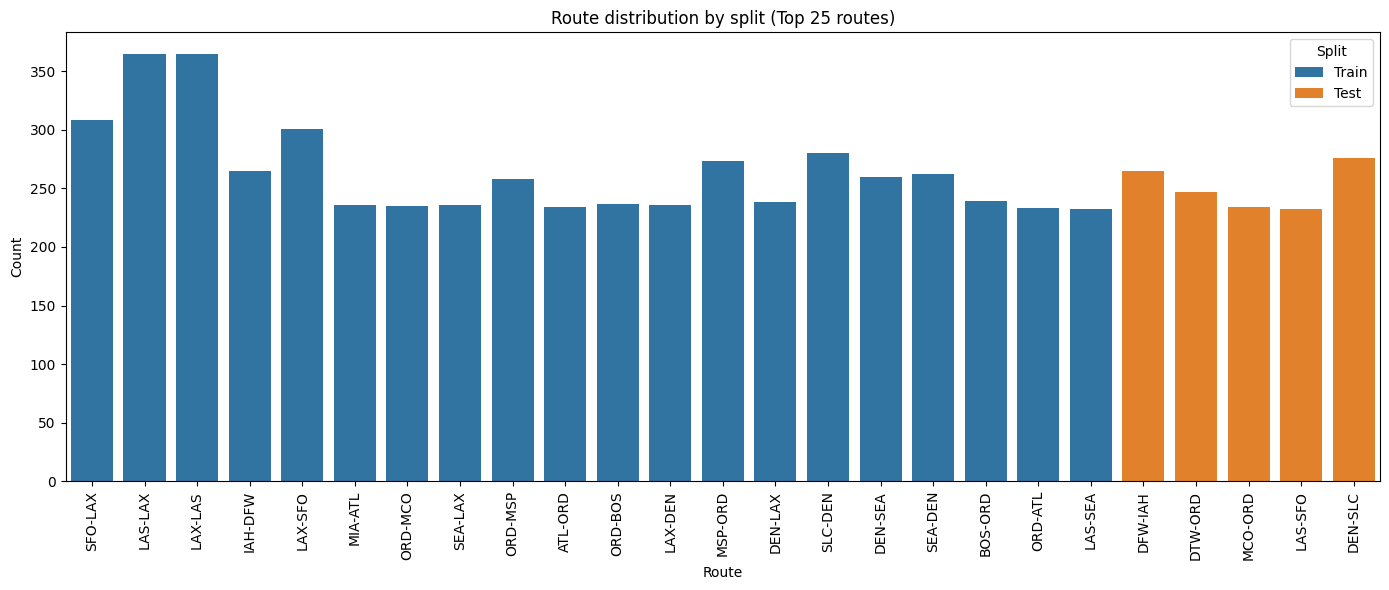

In [20]:
# Check overlap
train_routes = set(X_train_route["route"])
test_routes  = set(X_test_route["route"])

overlap = train_routes & test_routes
print(f"# Train routes: {len(train_routes)}")
print(f"# Test routes : {len(test_routes)}")
print(f"# Overlap     : {len(overlap)}")
if overlap:
    print("Example overlaps:", list(sorted(overlap))[:10])
else:
    print("No route appears in both Train and Test.")

# Visualize
train_vis = X_train_route[["route"]].copy()
train_vis["split"] = "Train"
test_vis = X_test_route[["route"]].copy()
test_vis["split"] = "Test"

vis_df = pd.concat([train_vis, test_vis], axis=0, ignore_index=True)

# Top N routes
N = 25
top_routes = (vis_df["route"].value_counts().head(N).index)
plot_df = vis_df[vis_df["route"].isin(top_routes)]

plt.figure(figsize=(14, 6))
ax = sns.countplot(data=plot_df, x="route", hue="split")
ax.set_title(f"Route distribution by split (Top {N} routes)")
ax.set_xlabel("Route")
ax.set_ylabel("Count")
plt.xticks(rotation=90)
plt.legend(title="Split")
plt.tight_layout()
plt.show()

**Model Evaluation for new routes**

In [21]:
evaluation_results_route = []

group_cv = GroupKFold(n_splits=3)
cv_groups = X_train_route["route"]  

for name, model in models.items():
    pipeline_route = Pipeline([
        ("preprocessing", preprocessor_new),  # Use new routes preprocessor (excludes route)
        ("model", model)
    ])

    # Cross-validation 
    cv = cross_validate(pipeline_route, X_train_route, y_train_route, cv=group_cv.split(X_train_route, y_train_route, groups=cv_groups), scoring={"r2": "r2", "mae": "neg_mean_absolute_error", "rmse": "neg_root_mean_squared_error"}, n_jobs=-1, return_train_score=False)

    # Train the model
    pipeline_route.fit(X_train_route, y_train_route)

    # Predict target
    y_pred_route = pipeline_route.predict(X_test_route)

    evaluation_results_route.append({
        "Model": name,
        "CV_R2_Mean": np.mean(cv["test_r2"]),
        "CV_MAE_Mean": -np.mean(cv["test_mae"]),
        "CV_RMSE_Mean": -np.mean(cv["test_rmse"]),
        "Test_R2": r2_score(y_test_route, y_pred_route),  
        "Test_MAE": mean_absolute_error(y_test_route, y_pred_route),  
        "Test_RMSE": np.sqrt(mean_squared_error(y_test_route, y_pred_route))  
    })

# Convert results to DataFrame
results_df_route = pd.DataFrame(evaluation_results_route).sort_values("Test_R2", ascending=False)
results_df_route

,Model,CV_R2_Mean,CV_MAE_Mean,CV_RMSE_Mean,Test_R2,Test_MAE,Test_RMSE
2,Random Forest,0.454071,0.114208,0.154032,0.480989,0.112169,0.151386
3,Gradient Boosting,0.441492,0.116151,0.155799,0.470809,0.113998,0.152864
1,Linear Regression,0.397902,0.119941,0.161765,0.431746,0.117538,0.158405
0,Baseline (Mean),-0.000056,0.159622,0.208488,-0.000003,0.161006,0.210135


**Identify the best performing model**

In [22]:
# Identify best model
best_row_route = results_df_route.loc[results_df_route["Test_R2"].idxmax()]

best_model_name_route = best_row_route["Model"]
best_model_r2_route = best_row_route["Test_R2"]
best_model_mae_route = best_row_route["Test_MAE"]
best_model_rmse_route = best_row_route["Test_RMSE"]

print("Best Performing Model (by R²):")
print(f"Model: {best_model_name_route}")
print(f"R² on Test Set: {best_model_r2_route:.3f}")
print(f"MAE on Test Set: {best_model_mae_route:.3f}")
print(f"RMSE on Test Set: {best_model_rmse_route:.3f}")

Best Performing Model (by R²):
Model: Random Forest
R² on Test Set: 0.481
MAE on Test Set: 0.112
RMSE on Test Set: 0.151


**Prediction vs Actual and Residual Analysis**

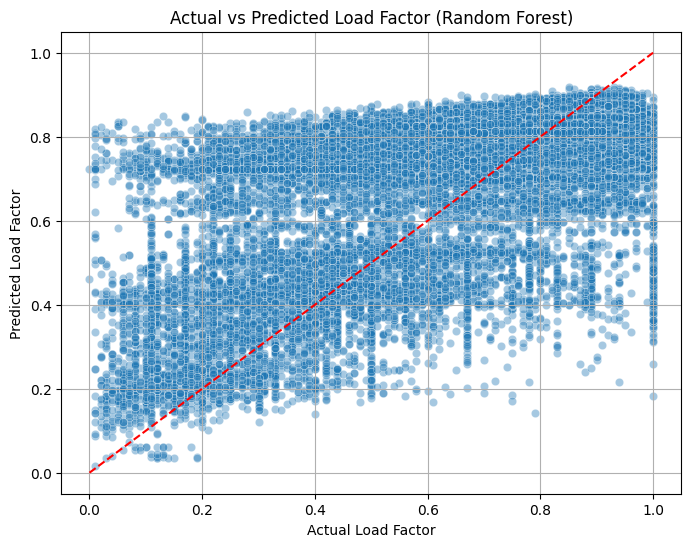

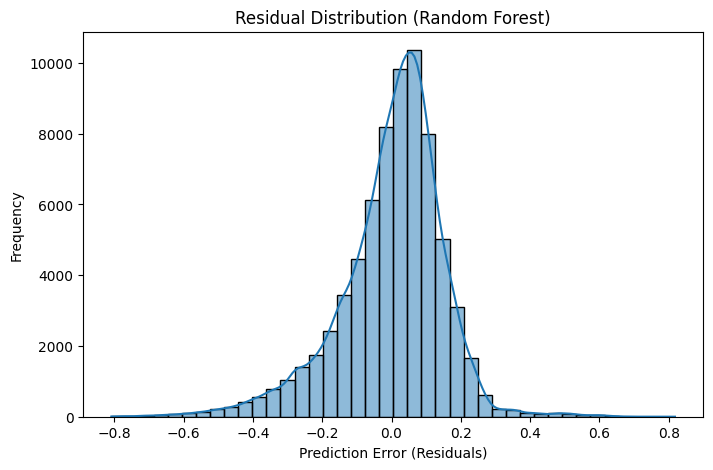

In [23]:
# Retrain best model on full training data and predict on test set
best_model_route = models[best_model_name_route]
best_pipeline_route = Pipeline([
    ("preprocessing", preprocessor_new),  # Use new routes preprocessor (excludes route)
    ("model", best_model_route)
])
best_pipeline_route.fit(X_train_route, y_train_route)
y_pred_route = best_pipeline_route.predict(X_test_route)

# Plot Actual vs Predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_route, y=y_pred_route, alpha=0.4)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title(f"Actual vs Predicted Load Factor ({best_model_name_route})")
plt.xlabel("Actual Load Factor")
plt.ylabel("Predicted Load Factor")
plt.grid(True)
plt.show()

# Residuals Plot - Fixed: use y_test_route instead of y_test
residuals_route = y_test_route - y_pred_route
plt.figure(figsize=(8,5))
sns.histplot(residuals_route, bins=40, kde=True)
plt.title(f"Residual Distribution ({best_model_name_route})")
plt.xlabel("Prediction Error (Residuals)")
plt.ylabel("Frequency")
plt.show()

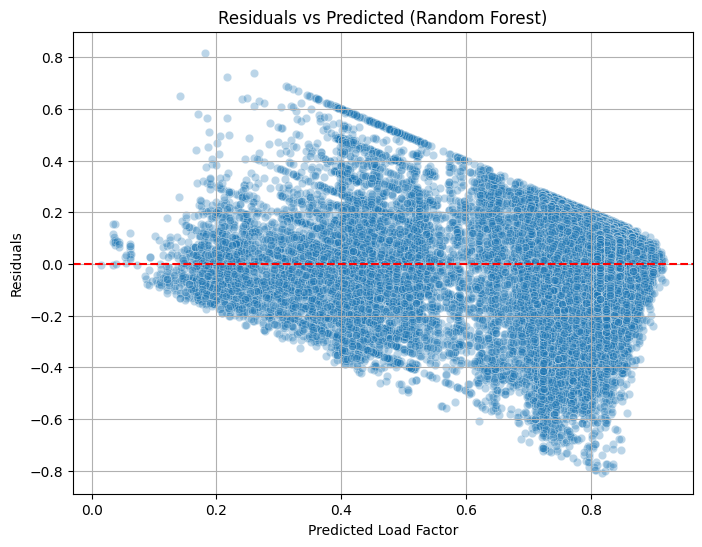

In [24]:
# Plot Predicted vs Residuals
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_pred_route, y=residuals_route, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title(f"Residuals vs Predicted ({best_model_name_route})")
plt.xlabel("Predicted Load Factor")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

**Hyperparameter tuning of the best model**

In [25]:
# Use best model for hyperparameter tuning
best_model_route = models[best_model_name_route]

# Use sample for hyperparameter tuning to reduce computing (50000 samples)
sample_size = min(50000, len(X_train_route)) 
print(f"Using {sample_size} samples for hyperparameter tuning (out of {len(X_train_route)} total)")

# Sample training data while maintaining route distribution
unique_routes = X_train_route["route"].unique()
np.random.seed(42)
# Use at least 30% of routes or sample_size/4, whichever is larger
min_routes = max(int(len(unique_routes) * 0.3), sample_size//4)
sampled_routes = np.random.choice(unique_routes, size=min(len(unique_routes), min_routes), replace=False)
sample_mask = X_train_route["route"].isin(sampled_routes)

X_train_sample = X_train_route[sample_mask].iloc[:sample_size]
y_train_sample = y_train_route[sample_mask].iloc[:sample_size]

print(f"Actual sample size: {len(X_train_sample)}")
print(f"Sample contains {X_train_sample['route'].nunique()} unique routes")

# Define focused parameter spaces based on best model type
if isinstance(best_model_route, RandomForestRegressor):
    params_route = {
        "model__n_estimators": randint(80, 200),   
        "model__max_depth": [8, 12, 16, 20],       
        "model__min_samples_split": [2, 5, 10],     
        "model__max_features": ["sqrt", "log2", 0.8] 
    }
elif isinstance(best_model_route, GradientBoostingRegressor):
    params_route = {
        "model__n_estimators": randint(80, 200),     
        "model__max_depth": [3, 5, 7],              
        "model__learning_rate": [0.05, 0.1, 0.15, 0.2], 
        "model__min_samples_split": [5, 10, 15]     
    }
elif isinstance(best_model_route, LinearRegression):
    params_route = [
        # Ridge Regression 
        {
            "model": [Ridge()],
            "model__alpha": [0.01, 0.1, 1.0, 10.0, 50.0] 
        },
        # Lasso Regression 
        {
            "model": [Lasso()],
            "model__alpha": [0.01, 0.1, 1.0, 10.0],
            "model__max_iter": [1000, 2000]
        }
    ]
else:
    params_route = None

if params_route is not None:
    # Create a new instance of the best model for tuning
    if isinstance(best_model_route, RandomForestRegressor):
        model_for_tuning_route = RandomForestRegressor(random_state=42, n_jobs=-1)
    elif isinstance(best_model_route, GradientBoostingRegressor):
        model_for_tuning_route = GradientBoostingRegressor(random_state=42)
    elif isinstance(best_model_route, LinearRegression):
        model_for_tuning_route = LinearRegression()
    
    # Define pipeline using the best model
    pipeline_route = Pipeline([
        ("preprocessing", preprocessor_new),
        ("model", model_for_tuning_route)
    ])
else:
    print("Using the original best model without additional tuning.")
    pipeline_route = None

# Only proceed with search if there are hyperparameters to tune
if pipeline_route is not None:
    cv = GroupKFold(n_splits=5)  
    cv_groups = X_train_sample["route"]
    
    if isinstance(best_model_route, LinearRegression):
        random_search_route = GridSearchCV(
            pipeline_route,
            param_grid=params_route,
            cv=cv,                      
            scoring="r2",              
            n_jobs=-1,                 
            verbose=1  
        )
    else:
        # For other models use RandomizedSearchCV 
        random_search_route = RandomizedSearchCV(
            pipeline_route,
            param_distributions=params_route,
            n_iter=35,  
            cv=cv,                      
            scoring="r2",              
            n_jobs=-1,                 
            verbose=1,  
            random_state=42
        )

    # Fit search on sample
    random_search_route.fit(X_train_sample, y_train_sample, groups=cv_groups)

    # Best parameters and score
    print("Best Parameters (from sample tuning):")
    print(random_search_route.best_params_)
    print(f"\nBest CV R² Score on Sample: {random_search_route.best_score_:.4f}")
    
    # Retrain best model on full training data
    print("\nRetraining best model on full training data...")
    best_pipeline_route = random_search_route.best_estimator_
    best_pipeline_route.fit(X_train_route, y_train_route)
    print("Retraining completed.")
else:
    print("Skipping hyperparameter tuning - not applicable for the current best model.")

Using 50000 samples for hyperparameter tuning (out of 288446 total)
Actual sample size: 50000
Sample contains 11607 unique routes
Fitting 5 folds for each of 35 candidates, totalling 175 fits
Best Parameters (from sample tuning):
{'model__max_depth': 16, 'model__max_features': 0.8, 'model__min_samples_split': 5, 'model__n_estimators': 167}

Best CV R² Score on Sample: 0.3994

Retraining best model on full training data...
Retraining completed.


**Evaluate the best tuned model on the test set**

In [26]:
# Select best estimator
best_pipeline_route = random_search_route.best_estimator_   
y_pred_route = best_pipeline_route.predict(X_test_route)

# Evaluation metrics
r2  = r2_score(y_test_route, y_pred_route)
mae = mean_absolute_error(y_test_route, y_pred_route)
rmse = np.sqrt(mean_squared_error(y_test_route, y_pred_route))

print("Test R²:",  round(r2, 3))
print("Test MAE:", round(mae, 3))
print("Test RMSE:", round(rmse, 3))

Test R²: 0.511
Test MAE: 0.108
Test RMSE: 0.147


**Hyperparameter tuning results analysis**

Performance Comparison (Route based Split):
                    Model      R2     MAE    RMSE
0  Original Random Forest  0.4810  0.1122  0.1514
1     Tuned Random Forest  0.5112  0.1083  0.1469

Performance Changes after Tuning:
R² change: 0.0302 (improvement)
MAE change: -0.0039 (improvement)
RMSE change: -0.0045 (improvement)

Best parameters found:
model__max_depth: 16
model__max_features: 0.8
model__min_samples_split: 5
model__n_estimators: 167


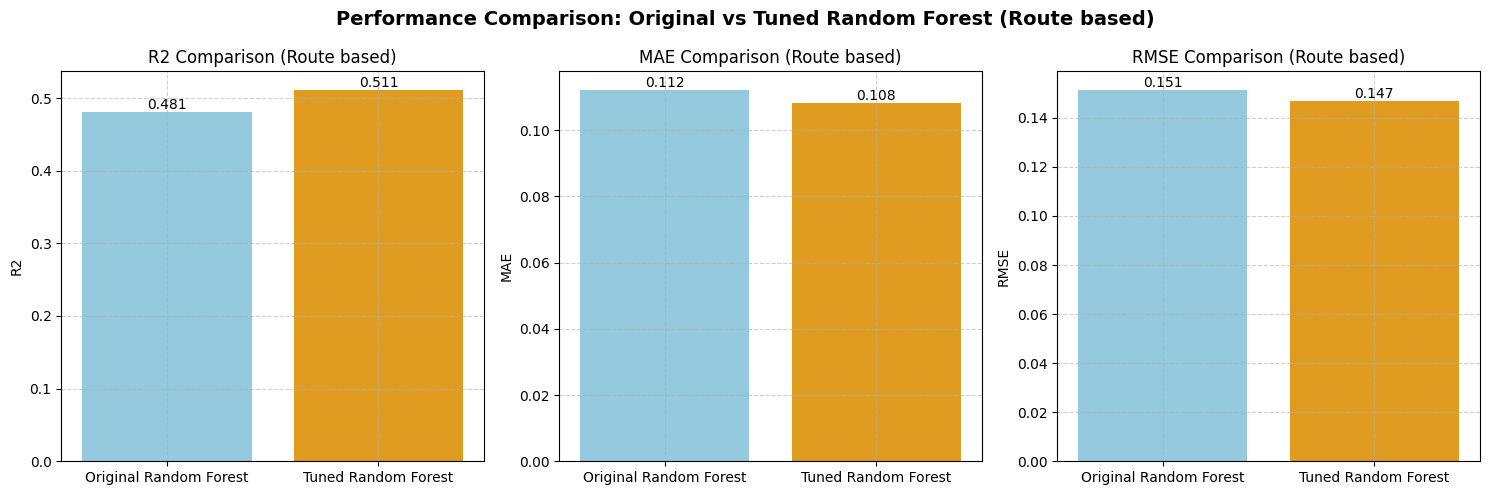

In [27]:
# Compare the original model vs the tuned version
# Initial model (using the best performing model from initial comparison)
initial_model_route = Pipeline([
    ("preprocessing", preprocessor_new),
    ("model", best_model_route)  
])
initial_model_route.fit(X_train_route, y_train_route)
y_pred_initial_route = initial_model_route.predict(X_test_route)

initial_results_route = {
    "Model": f"Original {best_model_name_route}",
    "R2": r2_score(y_test_route, y_pred_initial_route),
    "MAE": mean_absolute_error(y_test_route, y_pred_initial_route),
    "RMSE": np.sqrt(mean_squared_error(y_test_route, y_pred_initial_route)),
}

# Tuned model (from hyperparameter search)
best_tuned_route = random_search_route.best_estimator_
y_pred_tuned_route = best_tuned_route.predict(X_test_route)

tuned_results_route = {
    "Model": f"Tuned {best_model_name_route}",
    "R2": r2_score(y_test_route, y_pred_tuned_route),
    "MAE": mean_absolute_error(y_test_route, y_pred_tuned_route),
    "RMSE": np.sqrt(mean_squared_error(y_test_route, y_pred_tuned_route))
}

# Compare results
compare_df_route = pd.DataFrame([initial_results_route, tuned_results_route])
print("Performance Comparison (Route based Split):")
print(compare_df_route.round(4))

# Calculate improvement/degradation
r2_change_route = tuned_results_route["R2"] - initial_results_route["R2"]
mae_change_route = tuned_results_route["MAE"] - initial_results_route["MAE"]
rmse_change_route = tuned_results_route["RMSE"] - initial_results_route["RMSE"]

print(f"\nPerformance Changes after Tuning:")
print(f"R² change: {r2_change_route:.4f} ({'improvement' if r2_change_route > 0 else 'degradation'})")
print(f"MAE change: {mae_change_route:.4f} ({'improvement' if mae_change_route < 0 else 'degradation'})")
print(f"RMSE change: {rmse_change_route:.4f} ({'improvement' if rmse_change_route < 0 else 'degradation'})")

# Check the best parameters found
print(f"\nBest parameters found:")
for param, value in random_search_route.best_params_.items():
    print(f"{param}: {value}")

# Visualize comparison
metrics = ["R2", "MAE", "RMSE"]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, metric in enumerate(metrics):
    sns.barplot(
        data=compare_df_route,
        x="Model",
        y=metric,
        ax=axes[i],
        palette=["skyblue", "orange"]
    )
    axes[i].set_title(f"{metric} Comparison (Route based)")
    axes[i].set_xlabel("")
    axes[i].set_ylabel(metric)
    axes[i].grid(True, linestyle="--", alpha=0.6)
    
    # Add value labels on bars
    for container in axes[i].containers:
        axes[i].bar_label(container, fmt='%.3f')

plt.suptitle(f"Performance Comparison: Original vs Tuned {best_model_name_route} (Route based)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

**Grid Search for fine-tuning the best model**

In [28]:
# Grid search parameter space with reasonable bounds based on best model
if isinstance(best_model_route, RandomForestRegressor):
    gs_params_route = {
        "model__n_estimators": [100, 120],          
        "model__max_depth": [10, 12, 15],           
        "model__min_samples_split": [2, 5],         
        "model__max_features": ["sqrt", "log2"]     
    }
    model_for_gs_route = RandomForestRegressor(random_state=42)
elif isinstance(best_model_route, GradientBoostingRegressor):
    gs_params_route = {
        "model__n_estimators": [100, 150, 200],
        "model__max_depth": [3, 5, 7],
        "model__learning_rate": [0.1, 0.15, 0.2]
    }
    model_for_gs_route = GradientBoostingRegressor(random_state=42)
elif isinstance(best_model_route, LinearRegression):
    print("For Linear Regression, grid search would be redundant with the randomized search already performed.")
    gs_params_route = None
    model_for_gs_route = None
else:
    print(f"Grid search not implemented for {type(best_model_route).__name__}")
    gs_params_route = None
    model_for_gs_route = None

if gs_params_route is not None:
    # GridSearchCV with reduced search space
    gs_pipeline_route = Pipeline([
        ("preprocessing", preprocessor_new),
        ("model", model_for_gs_route)
    ])

    cv = GroupKFold(n_splits=5)
    cv_groups = X_train_route["route"]

    gs_search_route = GridSearchCV(
        gs_pipeline_route,
        param_grid=gs_params_route,
        cv=cv,
        scoring="r2",
        n_jobs=-1,
        verbose=1
    )

    gs_search_route.fit(X_train_route, y_train_route, groups=cv_groups)

    print("Best Grid Search Parameters:")
    print(gs_search_route.best_params_)
    print(f"Best CV R² Score: {gs_search_route.best_score_:.4f}")

    # Test the grid search model
    y_pred_gs_route = gs_search_route.best_estimator_.predict(X_test_route)
    gs_r2_route = r2_score(y_test_route, y_pred_gs_route)
    gs_mae_route = mean_absolute_error(y_test_route, y_pred_gs_route)
    gs_rmse_route = np.sqrt(mean_squared_error(y_test_route, y_pred_gs_route))

    print(f"\nGrid Search Model Test Results (new routes):")
    print(f"R²: {gs_r2_route:.4f}")
    print(f"MAE: {gs_mae_route:.4f}")
    print(f"RMSE: {gs_rmse_route:.4f}")

    # Compare all three approaches
    comparison_data_route = [
        {"Model": f"Original {best_model_name_route}", "R2": initial_results_route["R2"], "MAE": initial_results_route["MAE"], "RMSE": initial_results_route["RMSE"]},
        {"Model": f"Randomized Search", "R2": tuned_results_route["R2"], "MAE": tuned_results_route["MAE"], "RMSE": tuned_results_route["RMSE"]},
        {"Model": f"Grid Search", "R2": gs_r2_route, "MAE": gs_mae_route, "RMSE": gs_rmse_route}
    ]

    final_comparison_route = pd.DataFrame(comparison_data_route)
    print("\n" + "="*50)
    print("Final Comparison (new routes):")
    print("="*50)
    print(final_comparison_route.round(4))
else:
    print("Skipping grid search - not applicable for the current best model or would be redundant.")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Grid Search Parameters:
{'model__max_depth': 15, 'model__max_features': 'sqrt', 'model__min_samples_split': 2, 'model__n_estimators': 120}
Best CV R² Score: 0.4509

Grid Search Model Test Results (new routes):
R²: 0.4764
MAE: 0.1141
RMSE: 0.1521

Final Comparison (new routes):
                    Model      R2     MAE    RMSE
0  Original Random Forest  0.4810  0.1122  0.1514
1       Randomized Search  0.5112  0.1083  0.1469
2             Grid Search  0.4764  0.1141  0.1521


**Summarize best model insights for new route pax load prediction**

In [29]:
# Determine the best performing approach from all experiments
best_search_results = []

# Add RandomizedSearch results if available
if 'random_search_route' in locals() and hasattr(random_search_route, 'best_score_'):
    rs_test_pred = random_search_route.best_estimator_.predict(X_test_route)
    best_search_results.append({
        'method': 'Randomized Search',
        'estimator': random_search_route.best_estimator_,
        'params': random_search_route.best_params_,
        'cv_score': random_search_route.best_score_,
        'test_r2': r2_score(y_test_route, rs_test_pred),
        'test_pred': rs_test_pred
    })

# Add GridSearch results if available  
if 'gs_search_route' in locals() and hasattr(gs_search_route, 'best_score_'):
    gs_test_pred = gs_search_route.best_estimator_.predict(X_test_route)
    best_search_results.append({
        'method': 'Grid Search',
        'estimator': gs_search_route.best_estimator_,
        'params': gs_search_route.best_params_,
        'cv_score': gs_search_route.best_score_,
        'test_r2': r2_score(y_test_route, gs_test_pred),
        'test_pred': gs_test_pred
    })

# Add initial model results if available
if 'best_pipeline_route' in locals():
    initial_test_pred = best_pipeline_route.predict(X_test_route)
    best_search_results.append({
        'method': f'Initial {best_model_name_route}',
        'estimator': best_pipeline_route,
        'params': best_pipeline_route.named_steps["model"].get_params(),
        'cv_score': None,  # No CV score for initial model
        'test_r2': r2_score(y_test_route, initial_test_pred),
        'test_pred': initial_test_pred
    })

# Select the best approach based on test R²
if best_search_results:
    best_approach = max(best_search_results, key=lambda x: x['test_r2'])
    
    # Extract best model information
    best_estimator = best_approach['estimator']
    best_params = best_approach['params']
    best_method = best_approach['method']
    y_pred_best = best_approach['test_pred']
    
    print(f"Best performing approach: {best_method}")
    print(f"Test R²: {best_approach['test_r2']:.4f}")
else:
    print("No search results available")
    best_estimator = None

# Generate summary only if we have a best estimator
if best_estimator is not None:
    # Metrics summary
    summary_df = pd.DataFrame([{
        "Method": best_method,
        "Model": type(best_estimator.named_steps["model"]).__name__,
        "Best CV R²": round(best_approach['cv_score'], 4) if best_approach['cv_score'] is not None else "N/A",
        "Test R²": round(best_approach['test_r2'], 4), 
        "Test MAE": round(mean_absolute_error(y_test_route, y_pred_best), 4),
        "Test RMSE": round(np.sqrt(mean_squared_error(y_test_route, y_pred_best)), 4)
    }])

    # Hyperparameters overview 
    if isinstance(best_params, dict) and best_params:
        # Filter out None values
        filtered_params = {k: v for k, v in best_params.items() if v is not None}
        if filtered_params:
            params_df = pd.DataFrame(filtered_params, index=[0]).T
            params_df.columns = ["Value"]
        else:
            params_df = pd.DataFrame({"Parameter": ["Default"], "Value": ["Model defaults used"]})
    else:
        params_df = pd.DataFrame({"Parameter": ["Default"], "Value": ["Model defaults used"]})

    # Styled output
    display(Markdown("### Best Model Summary"))
    display(summary_df.style
        .hide(axis='index')
        .set_properties(**{
         'background-color': '#f8f9fa',
         'border-color': '#ccc',
         'border-width': '1px',
         'border-style': 'solid',
         'text-align': 'center',
         'color': "#010408"
    }).set_table_styles([
        {'selector': 'th', 'props': [('background-color', "#aec7e7"), ('font-weight', 'bold'), ('color', "#010408")]}
    ]))

    display(Markdown("### Best Hyperparameters"))
    display(params_df.style.set_properties(**{
        'background-color': '#f8f9fa',
        'border-color': '#ccc',
        'text-align': 'left',
        'color': "#010408"
    }).set_table_styles([
        {'selector': 'th', 'props': [('background-color', "#aec7e7"), ('font-weight', 'bold'), ('color', "#010408")]}
    ]))
else:
    print("No model results to display")


Best performing approach: Randomized Search
Test R²: 0.5112


### Best Model Summary

Method,Model,Best CV R²,Test R²,Test MAE,Test RMSE
Randomized Search,RandomForestRegressor,0.399400,0.511200,0.108300,0.146900


### Best Hyperparameters

,Value
model__max_depth,16.000000
model__max_features,0.800000
model__min_samples_split,5.000000
model__n_estimators,167.000000


**Feature importance analysis (SHAP vs. Coefficients) based on a data sample**

Performing SHAP analysis for tree-based model
Using 1000 samples for SHAP analysis (out of 70973 total)


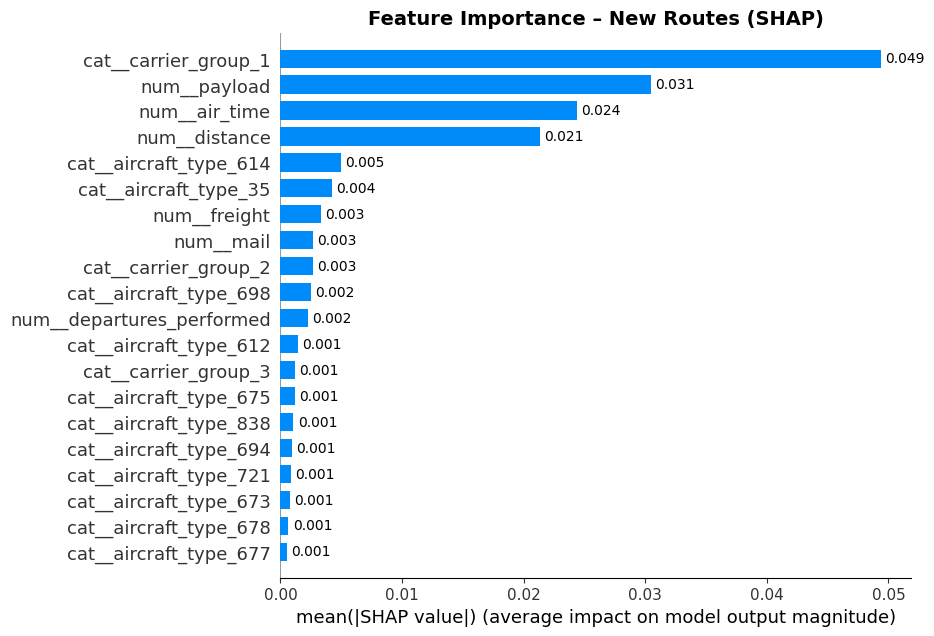

In [30]:
# Define best pipeline
best_pipeline_route = Pipeline([
    ("preprocessing", preprocessor_new),
    ("model", best_model_route)
])
best_pipeline_route.fit(X_train_route, y_train_route)

# Extract the trained model and transformed test data
model_route = best_pipeline_route.named_steps["model"]
X_test_transformed_route = best_pipeline_route.named_steps["preprocessing"].transform(X_test_route)

# Convert sparse matrix to dense array for analysis
if hasattr(X_test_transformed_route, 'toarray'):
    X_test_transformed_route = X_test_transformed_route.toarray()

# Get feature names
feature_names_route = best_pipeline_route.named_steps["preprocessing"].get_feature_names_out()

# Check model type and apply appropriate analysis
if isinstance(model_route, (RandomForestRegressor, GradientBoostingRegressor)):
    print("Performing SHAP analysis for tree-based model")
    
    # Use a sample for faster SHAP analysis (1000 samples)
    sample_size = min(1000, X_test_transformed_route.shape[0])  
    print(f"Using {sample_size} samples for SHAP analysis (out of {X_test_transformed_route.shape[0]} total)")

    # Take a random sample
    np.random.seed(42)
    sample_indices_route = np.random.choice(X_test_transformed_route.shape[0], sample_size, replace=False)
    X_sample_route = X_test_transformed_route[sample_indices_route]

    # SHAP TreeExplainer for tree-based models
    explainer_route = shap.TreeExplainer(model_route)
    shap_values_route = explainer_route.shap_values(X_sample_route)

    # Summary Plot 
    shap_fig = shap.summary_plot(
        shap_values_route,
        X_sample_route,
        feature_names=feature_names_route,
        plot_type="bar",
        show=False
    )
    # Adjust figure size and layout
    fig = plt.gcf()
    fig.set_size_inches(10, 7)                
    fig.subplots_adjust(bottom=0.4, right=0.95)  

    # Access the current axis
    ax = plt.gca()

    # Add bar labels
    for container in ax.containers:
        ax.bar_label(container, fmt="%.3f", label_type="edge", padding=3)

    # Add title manually
    plt.title("Feature Importance – New Routes (SHAP)", fontsize=14, fontweight="bold")

    # Show plot
    plt.tight_layout(pad=3.0)
    plt.show()
    

elif isinstance(model_route, LinearRegression):
    print("Performing coefficient analysis for Linear Regression")
    
    # For Linear Regression show feature coefficients instead of SHAP
    coefficients = model_route.coef_
    
    # Create coefficient importance plot
    coef_df = pd.DataFrame({
        'Feature': feature_names_route,
        'Coefficient': coefficients,
        'Abs_Coefficient': np.abs(coefficients)
    }).sort_values('Abs_Coefficient', ascending=True)
    
    # Plot top 20 features
    top_features = coef_df.tail(20)
    
    plt.figure(figsize=(12, 10)) 
    colors = ['red' if x < 0 else 'blue' for x in top_features['Coefficient']]
    bars = plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors)
    plt.yticks(range(len(top_features)), top_features['Feature'], fontsize=10) 
    plt.xlabel('Coefficient Value', fontsize=12)
    plt.title('Top 20 Feature Coefficients – New Routes (Linear Regression)', fontsize=14, fontweight="bold")
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    # Add value labels on bars
    for i, (bar, coef) in enumerate(zip(bars, top_features['Coefficient'])):
        if coef > 0:
            plt.text(coef - 0.05, i, f'{coef:.3f}', ha='right', va='center', color='white', fontsize=9, fontweight='bold')
        else:
            plt.text(coef + 0.05, i, f'{coef:.3f}', ha='left', va='center', color='white', fontsize=9, fontweight='bold')

    # Adjust layout to prevent label cutoff
    plt.tight_layout(pad=2.0)
    plt.subplots_adjust(left=0.45, right=0.95)  
    plt.show()
    
    print(f"Linear Regression R² Score: {model_route.score(X_test_transformed_route, y_test_route):.4f}")
    print(f"Number of features: {len(coefficients)}")
    print(f"Features with positive impact: {sum(coefficients > 0)}")
    print(f"Features with negative impact: {sum(coefficients < 0)}")

else:
    print(f"Feature importance analysis not implemented for {type(model_route).__name__}")
    print("Skipping feature importance visualization.")

**SHAP Beeswarm plot**

Creating SHAP beeswarm plot for tree-based model


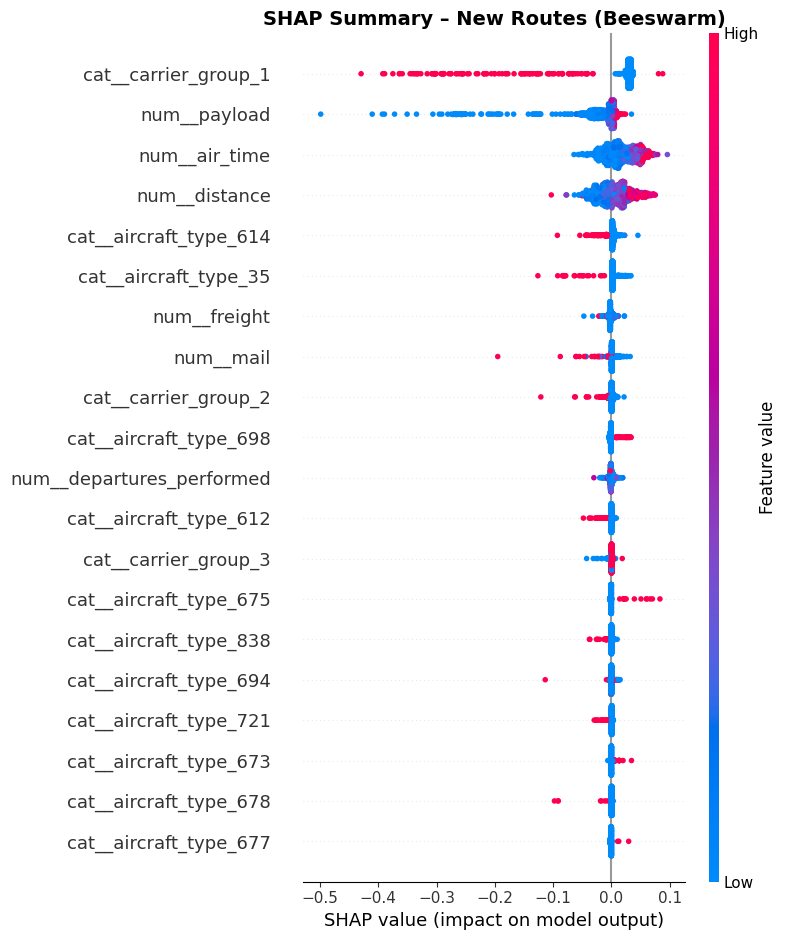

In [31]:
# SHAP Beeswarm plot (only for tree-based models)
if isinstance(model_route, (RandomForestRegressor, GradientBoostingRegressor)):
    print("Creating SHAP beeswarm plot for tree-based model")
    
    shap.summary_plot(
        shap_values_route,
        X_sample_route,
        feature_names=feature_names_route,
        show=False
    )
    plt.title("SHAP Summary – New Routes (Beeswarm)", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()
    
elif isinstance(model_route, LinearRegression):
    print("SHAP beeswarm plot not applicable for Linear Regression")
    print("Coefficient analysis was already shown above.")
    
else:
    print(f"SHAP beeswarm plot not implemented for {type(model_route).__name__}")
    print("Skipping beeswarm visualization.")


**Route-wise error analysis (best model)**

The prediction errors are calculated for each route by comparing actual and predicted load factors. Aggregating the mean absolute error per route helps identify patterns or outliers in model performance.

In [32]:
# Error per route analysis
errors_df = X_test_route.copy()
errors_df["y_true"] = y_test_route
errors_df["y_pred"] = y_pred_route
errors_df["abs_error"] = abs(errors_df["y_true"] - errors_df["y_pred"])

route_error = (
    errors_df
    .groupby("route")[["y_true", "y_pred", "abs_error"]]
    .mean()
    .round(4)
    .sort_values("abs_error")
)
route_error.round(4).tail(25)


,y_true,y_pred,abs_error
route,,,
SCE-BED,1.000,0.4063,0.5937
SQL-BFI,1.000,0.4040,0.5960
TTN-JFK,1.000,0.4028,0.5972
SNA-MIV,0.910,0.3122,0.5978
SPG-EYW,1.000,0.3984,0.6016
EYW-SPG,1.000,0.3984,0.6016
KWT-HPB,1.000,0.3958,0.6042
PBI-PDX,0.930,0.3225,0.6075
YAK-SEA,0.205,0.8139,0.6089


**Summary statistics of route-level prediction errors**

Key error metrics are summarized across all routes to assess overall prediction quality. This provides an overview of average accuracy and the share of routes with higher-than-expected errors.

In [33]:
n_routes = len(route_error)
global_mae = mean_absolute_error(y_test_route, y_pred_route)
mean_abs_error = route_error["abs_error"].mean()
median_abs_error = route_error["abs_error"].median()
high_error_03 = (route_error["abs_error"] > 0.3).sum()
high_error_05 = (route_error["abs_error"] > 0.5).sum()

share_03 = high_error_03 / n_routes * 100
share_05 = high_error_05 / n_routes * 100

print(f"Number of routes: {n_routes}")
print(f"Global MAE (all flights): {global_mae:.3f}")
print(f"Mean abs. error per route: {mean_abs_error:.3f}")
print(f"Median abs. error per route: {median_abs_error:.3f}")
print(f"Routes with MAE > 0.3: {high_error_03} ({share_03:.1f}%)")
print(f"Routes with MAE > 0.5: {high_error_05} ({share_05:.1f}%)")

Number of routes: 4480
Global MAE (all flights): 0.108
Mean abs. error per route: 0.156
Median abs. error per route: 0.125
Routes with MAE > 0.3: 436 (9.7%)
Routes with MAE > 0.5: 66 (1.5%)


**Model Performance by Load Factor Range**

To see how well the model performs for different load levels, the test data is divided into three load factor groups:
- low (<0.5)
- medium (0.5–0.7)
- high (>0.7) 


Since the sample size and variance differ between these groups, the R² score is not always a reliable indicator of performance, especially in smaller or low-variance subsets, where it can take negative values. Therefore, only the MAE and RMSE are used as metrics.

,Load Factor Range,Count,MAE,RMSE
0,Low (<0.5),9942,0.2075,0.2582
1,Medium (0.5–0.7),11292,0.1353,0.1527
2,High (>0.7),49739,0.0823,0.1103


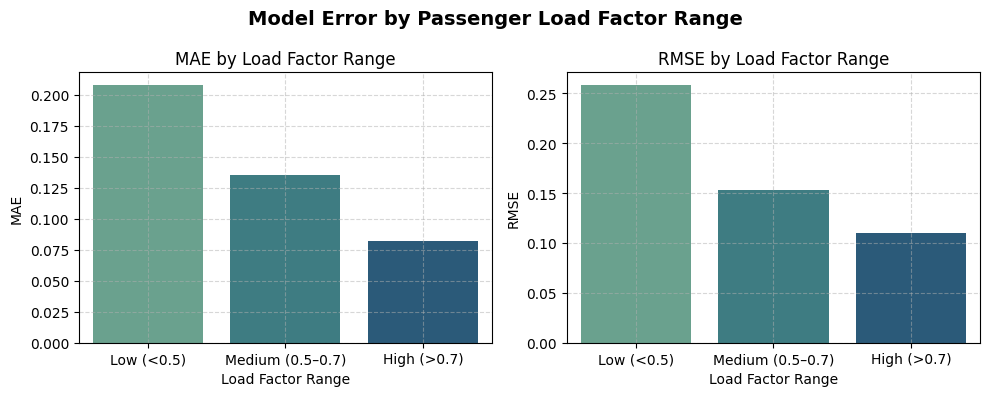

In [ ]:
# Combine true and predicted values
performance_df = pd.DataFrame({
    "y_true": y_test_route.values,
    "y_pred": y_pred_route
})

# Define bins for passenger load factor
bins = [0, 0.5, 0.7, 1.0]
labels = ["Low (<0.5)", "Medium (0.5–0.7)", "High (>0.7)"]
performance_df["load_bin"] = pd.cut(performance_df["y_true"], bins=bins, labels=labels, include_lowest=True)

#  Error metrics per bin
bin_metrics = []
for name, group in performance_df.groupby("load_bin"):
    mae = mean_absolute_error(group["y_true"], group["y_pred"])
    rmse = np.sqrt(mean_squared_error(group["y_true"], group["y_pred"]))
    bin_metrics.append({"Load Factor Range": name, "Count": len(group), "MAE": mae, "RMSE": rmse})

bin_results = pd.DataFrame(bin_metrics).round(4)
display(bin_results)

# Plot error metrics per bin
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.barplot(data=bin_results, x="Load Factor Range", y="MAE", ax=ax[0], palette="crest")
ax[0].set_title("MAE by Load Factor Range")
ax[0].grid(True, linestyle="--", alpha=0.5)

sns.barplot(data=bin_results, x="Load Factor Range", y="RMSE", ax=ax[1], palette="crest")
ax[1].set_title("RMSE by Load Factor Range")
ax[1].grid(True, linestyle="--", alpha=0.5)

plt.suptitle("Model Error by Passenger Load Factor Range", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

In [34]:
# Save model for deployment
best_model_to_save = random_search_route.best_estimator_
joblib.dump(best_model_to_save, '../model/passenger_load_model.joblib')

# Display model information
model_type = best_model_to_save.named_steps['model'].__class__.__name__
model_mae = round(mean_absolute_error(y_test_route, y_pred_best), 4)
model_r2 = round(best_approach['test_r2'], 4)

print(f"Model type: {model_type}")
print(f"Method: {best_method}")
print(f"MAE: {model_mae}")
print(f"R²: {model_r2}")
print("Model saved successfully!")

Model type: RandomForestRegressor
Method: Randomized Search
MAE: 0.1083
R²: 0.5112
Model saved successfully!
